In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

In [2]:
#loading the data 
link = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
path = tf.keras.utils.get_file('mnist.npz',link)
data = np.load(path)
x_coord_train , y_coord_train = data["x_train"], data["y_train"]
x_coord_test , y_coord_test = data["x_test"], data["y_test"]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Question - 1

In [3]:
selected_classes = [0, 1] # making the array for the classes we want 
select_val_train = np.isin(y_coord_train, selected_classes) # using the np.isin function to get the selected classes
select_val_test = np.isin(y_coord_test, selected_classes) # using the np.isin function to get the selected classes
x_selected_train = x_coord_train[select_val_train] #selected x_train data -- the value of n is close to 18000
y_selected_train = y_coord_train[select_val_train] #selected y_train data -- the value of n is close to 18000
y_selected_train = np.where(y_selected_train == 0, -1, 1)  # changing the label 0 to -1 and 1 will remain 1
x_selected_test = x_coord_test[select_val_test] #selected x_test data -- the value of n is close to 3000
y_selected_test = y_coord_test[select_val_test] #selected y_test data -- the value of n is close to 3000
y_selected_test = np.where(y_selected_test == 0, -1, 1) # changing the label 0 to -1 and 1 will remain 1

Divide the train set into train and val set. Keep 1000 samples from each
class for val. Note val should be used to evaluate the performance of the
classifier. Must not be used in obtaining PCA matrix.

In [4]:
# dividing train set into train and val set . 
# indices_class_neg_1 = np.where(y_selected_train == -1)[0] # getting the indices of class -1
# indices_class_1 = np.where(y_selected_train == 1)[0] # getting the indices of class 1
# val_indices = np.concatenate((indices_class_neg_1[:1000] , indices_class_1[:1000])) # taking 1000 samples from each class 
# train_indices = np.concatenate((indices_class_neg_1[1000:] , indices_class_1[1000:])) # taking the rest of the samples for training
val_points = [] ; val_y = [] ; train_points = [] ; y_train_points = []
idx_class_neg1 = np.where(y_selected_train == -1)[0]
idx_class_1 = np.where(y_selected_train == 1)[0]
val_points.extend(x_selected_train[idx_class_neg1[:1000]])
val_points.extend(x_selected_train[idx_class_1[:1000]])
val_y.extend(y_selected_train[idx_class_neg1[:1000]])
val_y.extend(y_selected_train[idx_class_1[:1000]])
train_points.extend(x_selected_train[idx_class_neg1[1000:]])
train_points.extend(x_selected_train[idx_class_1[1000:]])
y_train_points.extend(y_selected_train[idx_class_neg1[1000:]])
y_train_points.extend(y_selected_train[idx_class_1[1000:]])

val_points = np.array(val_points) ; val_y = np.array(val_y) ; train_points = np.array(train_points) ; y_train_points = np.array(y_train_points)
print(val_points.shape)
# val_points = y_selected_train[val_indices] # getting the validation set
# train_points = x_selected_train[train_indices] # getting the validation set
# y_train_points = y_selected_train[train_indices] # getting the labels for the training set
# print(val_points.shape)
# print(train_points.shape)

(2000, 28, 28)


Apply PCA and reduce the dimension to p = 5. You can use the train set
of the two classes to obtain PCA matrix. For the remaining parts, use the
reduced dimension dataset.

In [5]:
# applying PCA matrix using the train_points 
p = 5
train_points = train_points.reshape(train_points.shape[0], -1)
# print(train_points.shape)
train_points = train_points.T 
mean_train_points = np.mean(train_points , axis=1 , keepdims=True)
train_centered = train_points - mean_train_points
S = (train_centered @ train_centered.T) / (train_centered.shape[1]- 1)
S_eigenvalues, S_eigenvectors = np.linalg.eig(S)
sorted_S = np.argsort(S_eigenvalues)[::-1]
S_eigenvalues = S_eigenvalues[sorted_S]
S_eigenvectors = S_eigenvectors[:, sorted_S]
U = S_eigenvectors
U_p = U[:, :p]
Y = U_p.T @ train_centered # applying the PCA matrix on the train_points to reduce the dimension of the data

print(Y.shape)

val_points = val_points.reshape(val_points.shape[0], -1)
val_points = val_points.T
mean_val_points = np.mean(val_points , axis=1 , keepdims=True)
val_centered = val_points - mean_val_points
S_val = (val_centered @ val_centered.T) / (val_centered.shape[1]- 1)
S_eigenvalues_val, S_eigenvectors_val = np.linalg.eig(S_val)
sorted_S_val = np.argsort(S_eigenvalues_val)[::-1]
S_eigenvalues_val = S_eigenvalues_val[sorted_S_val]
S_eigenvectors_val = S_eigenvectors_val[:, sorted_S_val]
U_val = S_eigenvectors_val
U_p_val = U_val[:, :p]
X_val = U_p_val.T @ val_centered # applying the PCA matrix on the val_points to reduce the dimension of the data
print(X_val.shape)

test_points = x_selected_test.reshape(x_selected_test.shape[0], -1)
test_points = test_points.T
#mean_test_points = np.mean(test_points , axis=1 , keepdims=True)
test_centered = test_points - mean_train_points
S_test = (test_centered @ test_centered.T) / (test_centered.shape[1]- 1)
S_eigenvalues_test, S_eigenvectors_test = np.linalg.eig(S_test)
sorted_S_test = np.argsort(S_eigenvalues_test)[::-1]
S_eigenvalues_test = S_eigenvalues_test[sorted_S_test]
S_eigenvectors_test = S_eigenvectors_test[:, sorted_S_test]
U_test = S_eigenvectors
U_p_test = U_test[:, :p]
X_test = U_p_test.T @ test_centered # applying the PCA matrix on the test_points to reduce the dimension of the data



(5, 10665)
(5, 2000)


In [6]:
def loss(weight, unique , train_points , y_train_points): 
    min_loss = 1.5  ; min_mid = 0 ; indexes_weight_changed = []  ; final_left_predict = 0 ; final_right_predict = 0 
    mid_vals = ((unique[1:] + unique[:-1])/2)
    for j in range(len(mid_vals)):
        weights_changed_indices = []
        # predicted_left = [] 
        # predicted_right = [] 
        mid = mid_vals[j] 
        # print(mid) 
        train_points = np.array(train_points) ; weight = np.array(weight)
        # for k in range(len(train_points[dim])) : 
        #     if train_points[dim][k] < mid : 
        #         predicted_left.append(y_train_points[k])
        #         predicted_left_indices.append(k)
        #     else : 
        #         predicted_right.append(y_train_points[k])
        #         predicted_right_indices.append(k)
        # train_points = train_points.T     
        # decision_split = train_points[:,dim] < mid
        # # print(decision_split)
        # decision_less = weight[decision_split]
        # decision_more = weight[~decision_split]
        # less_chosen = y_train_points[decision_split]
        # more_chosen = y_train_points[~decision_split]
        # indices_less = np.where(decision_split)[0]
        # indices_more = np.where(~decision_split)[0]
        # train_points = train_points.T
        left_points = y_train_points[0:j] # taking first j points
        right_points = y_train_points[j:len(y_train_points)]  # taking the rest of the points
        weight_left = weight[0:j]   # taking the weights of the first j points
        weight_right = weight[j:len(weight)] # taking the weights of the rest of the points
        left_predict = 1 if np.sum(left_points) > 0 else -1 # making left prediction  
        right_predict = 1 if np.sum(right_points) > 0 else -1 # making right prediction 
        # count_neg1_left = predicted_left.count(-1) ; count_1_left = predicted_left.count(1) ; count_neg1_right = predicted_right.count(-1) ; count_1_right = predicted_right.count(1)   
        #print(count_neg1_left , count_1_left , count_neg1_right , count_1_right)
        # if count_neg1_left > count_1_left:
        #     left_predict = (-1) 
        # else: 
        #     left_predict = 1
        # if count_neg1_right > count_1_right:
        #     right_predict = (-1)
        # else:
        #     right_predict = 1    
        # count_neg1_left = np.sum(less_chosen == -1) ; count_1_left = np.sum(less_chosen == 1) ; count_neg1_right = np.sum(more_chosen == -1) ; count_1_right = np.sum(more_chosen == 1)
        # # print(count_neg1_left , count_1_left , count_neg1_right , count_1_right)
        # left_predict = -1 if count_neg1_left > count_1_left else 1
        # right_predict = -1 if count_neg1_right > count_1_right else 1   
        # missclassified_weight = 0  ; misclassified_less = 0 ; misclassified_more = 0    
        # misclassified_less = less_chosen != left_predict
        # misclassified_more = more_chosen != right_predict
        # missclassified_weight += np.sum(decision_less[misclassified_less])
        # missclassified_weight += np.sum(decision_more[misclassified_more])
        # weights_changed_indices.extend(indices_less[misclassified_less])
        # weights_changed_indices.extend(indices_more[misclassified_more])
        # for k in range(len(predicted_left)):
        #     total_weight += weight[predicted_left_indices[k]]            
        #     if predicted_left[k] != left_predict:
        #         missclassified_weight += weight[predicted_left_indices[k]]
        #         weights_changed_indices.append(predicted_left_indices[k])
        #         # print("1")
        # for k in range(len(predicted_right)):
        #     total_weight += weight[predicted_right_indices[k]]
        #     if predicted_right[k] != right_predict:
        #         missclassified_weight += weight[predicted_right_indices[k]]
        #         weights_changed_indices.append(predicted_right_indices[k])         
                # print("0")
        # print(total_weight)        
        # print(missclassified_weight / total_weight )        
        missclassified_weight = np.sum(weight_left[left_points != left_predict]) + np.sum(weight_right[right_points != right_predict]) ; total_weight = np.sum(weight)
        if (missclassified_weight / total_weight) < min_loss:
            min_loss = (missclassified_weight / total_weight)
            min_mid = mid
            indexes_weight_changed = weights_changed_indices
            final_left_predict = left_predict
            final_right_predict = right_predict
            
    return min_loss , min_mid , indexes_weight_changed , final_left_predict , final_right_predict
    

Now learn a decision tree using the train set. You need to grow a deci-
sion stump. For each dimension, find the unique values and sort them

in ascending order. The splits to be evaluated will be midpoint of two
consecutive unique values. Find the best split by minimizing weighted

1

miss-classification error. Denote this as h1(x). Note as we are dealing
with real numbers, each value may be unique. So just sorting them and
taking midpoint of consecutive values may also result in similar tree.

In [7]:
def learn_tree(train_set , weights):
    # train_set[i][j] -- means that we are at ith dimension and at jth point
    indexes_changed = [] ; midpoints=[] ; left_predictions = [] ; right_predictions = []
    # print(weights)
    min_losses = []
    for i in range(5):
        unique_points = np.unique(train_set[i]) 
        # for j in range(len(train_set[i])):
        #     if train_set[i][j] not in unique_points:
        #         unique_points.append(train_set[i][j])
        # unique_points.sort()
        # unique_points = np.random.choice(unique_points , 1000,replace=False)
        # print(len(unique_points))
        # print(unique_points)
        # print(weights)
        sorted_idx = np.argsort(train_set[i])
        train_set_sorted = train_set.T[sorted_idx].T
        y_train_points_sorted = y_train_points[sorted_idx] ; weights_sorted = np.array(weights)[sorted_idx]
        # print(train_set_sorted.shape , y_train_points_sorted.shape)
        min_loss , min_mid  , indexes_c , left_predict , right_predict= loss(weights_sorted , unique_points , train_set_sorted , y_train_points_sorted)
        midpoints.append(min_mid)
        # print(len(indexes_c))
        indexes_changed.append(indexes_c)
        
        # print(min_loss , min_mid)
        min_losses.append(min_loss)
        left_predictions.append(left_predict)                                                        
        right_predictions.append(right_predict)
        # print(unique_points)     
    min_dim = 0 ; min_loss_val = min_losses[0]  ; minloss_indexes = indexes_changed[0] ; splitat = midpoints[0] ; final_left_predict = left_predictions[0] ; final_right_predict = right_predictions[0]
    for i in range(1,len(min_losses)):
        if min_losses[i] < min_loss_val:
            min_loss_val = min_losses[i]
            min_dim = i
            minloss_indexes = indexes_changed[i]
            splitat = midpoints[i]
            final_left_predict = left_predictions[i]    
            final_right_predict = right_predictions[i]
    print("Minimum loss is coming at dimension:",min_dim , "and loss is coming :",min_loss_val , "and the split is happening at :",splitat)
    
# print(Y.shape)
    alpha1 = np.log((1 - min_loss_val) / min_loss_val)
    print("Alpha is : ",alpha1)
    # print(minloss_indexes)
    sorted_idx = np.argsort(train_set[min_dim])
    
    train_set_sorted = train_set.T[sorted_idx].T
    # print(train_set_sorted.shape)
    y_train_points_sorted = y_train_points[sorted_idx] 
    
    sorted_weights = np.array(weights)[sorted_idx]
    
    y_sorted_left = y_train_points_sorted[train_set_sorted[min_dim] < splitat] 
    
    y_sorted_right = y_train_points_sorted[train_set_sorted[min_dim] >= splitat]
    
    weights_less = sorted_weights[train_set_sorted[min_dim] < splitat]  
    
    weights_more = sorted_weights[train_set_sorted[min_dim] >= splitat]
    
    split_dec_left = 1 if np.sum(y_sorted_left) > 0 else -1 ; split_dec_right = 1 if np.sum(y_sorted_right) > 0 else -1
    
    weights_less[y_sorted_left != split_dec_left] = weights_less[y_sorted_left != split_dec_left] * ((1 - min_loss_val) / min_loss_val)
    
    weights_more[y_sorted_right != split_dec_right] = weights_more[y_sorted_right != split_dec_right] * ((1 - min_loss_val) / min_loss_val)
    
    sorted_weights = np.concatenate((weights_less , weights_more))
    
    first_idxeing = np.argsort(sorted_idx)
    
    weights = sorted_weights[first_idxeing]

    
        
    # for i in range(len(minloss_indexes)):
    #     weights[minloss_indexes[i]] = weights[minloss_indexes[i]] * ((1- min_loss_val) / min_loss_val)
    # # print(weights[11])     
    return min_dim , splitat , final_left_predict , final_right_predict , min_loss_val , alpha1 , weights
weights = [1/(len(Y[0]))] * (len(Y[0])) ; stored_dimensions = [] ; stored_splits = [] ; stored_left_predict = [] ; stored_right_predict = [] ; accuracy = [] ; alphas =[]
# making 300 decision stump trees
for i in range(300):
    min_dim , splitat , left_predict , right_predict , min_loss_val ,alpha1 , weights= learn_tree(Y , weights) 
    # print(weights)
    # print(weights[11])
    stored_dimensions.append(min_dim) ; stored_splits.append(splitat) ; stored_left_predict.append(left_predict) ; stored_right_predict.append(right_predict) ; alphas.append(alpha1)
    # print(stored_dimensions , stored_splits , stored_left_predict , stored_right_predict , alphas)
    true_classified = 0 
    for j in range(len(X_val[0])):
        f_x = 0 
        for k in range(0,i+1):
            f_x += (alphas[k] * (stored_left_predict[k] if X_val[stored_dimensions[k]][j] < stored_splits[k] else stored_right_predict[k]))
        if np.sign(f_x) == val_y[j]:
            true_classified += 1
    print(f"The accuracy for {i+1} trees is : {true_classified / len(X_val[0]) * 100} %")          
    accuracy.append(true_classified / len(X_val[0]))
plt.plot(range(1, 301), accuracy, marker='o', linestyle='-')
plt.title('Accuracy on val set vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy on val set')
plt.grid(True)
plt.show()
no_of_trees = 1 ; max_accuracy = accuracy[0]
for i in range(1 ,len(accuracy) ,1):
    if accuracy[i] >= max_accuracy:
        no_of_trees = i+1
        max_accuracy = accuracy[i]
print(f"The maximum accuracy is coming at {no_of_trees} trees and the accuracy is {max_accuracy * 100} %")

# seeing accuracy for test set 
true_classified = 0
for j in range(len(X_test[0])):
    f_x = 0
    for k in range(no_of_trees):
        f_x += (alphas[k] * (stored_left_predict[k] if X_test[stored_dimensions[k]][j] < stored_splits[k] else stored_right_predict[k]))
    if np.sign(f_x) == y_selected_test[j]:
        true_classified += 1
print(f"The accuracy for the test set is : {true_classified / len(X_test[0]) * 100} %")    
    





Minimum loss is coming at dimension: 0 and loss is coming : 0.004688232536333803 and the split is happening at : (192.72278407732904+0j)
Alpha is :  5.35800036870921
The accuracy for 1 trees is : 99.5 %
Minimum loss is coming at dimension: 0 and loss is coming : 0.24363727945600314 and the split is happening at : (637.0513407899206+0j)
Alpha is :  1.132840490536242
The accuracy for 2 trees is : 99.5 %
Minimum loss is coming at dimension: 0 and loss is coming : 0.19133761691827686 and the split is happening at : (-294.5555128102518+0j)
Alpha is :  1.4413420082504178
The accuracy for 3 trees is : 99.5 %
Minimum loss is coming at dimension: 3 and loss is coming : 0.2606771628395517 and the split is happening at : (143.1728062672899+0j)
Alpha is :  1.04245196461968
The accuracy for 4 trees is : 99.5 %
Minimum loss is coming at dimension: 1 and loss is coming : 0.284860067708763 and the split is happening at : (-250.317415392733+0j)
Alpha is :  0.9204801638458563
The accuracy for 5 trees is

KeyboardInterrupt: 

In [ ]:
#Question - 2 - normal
def loss_regressor(unique , train_points , y_train_points): 
    mid_vals = ((unique[1:] + unique[:-1])/2) ; SSR_arr = []; left_means = [] ;right_means = [] 
    for j in range(1,len(mid_vals)):
        mid = mid_vals[j] 
        train_points = np.array(train_points) ; 
        left_points = y_train_points[0:j] # taking first j points
        right_points = y_train_points[j:len(y_train_points)]  # taking the rest of the points
        # print(left_points , right_points)
        left_mean = np.mean(left_points) ; right_mean = np.mean(right_points)
        left_points = left_points - left_mean ; left_points = left_points**2  ; right_points = right_points - right_mean ; right_points = right_points**2
        sum_left = np.sum(left_points) ; sum_right = np.sum(right_points)
        SSR = sum_left + sum_right
        SSR_arr.append(SSR) ; 
        left_means.append(left_mean) ; right_means.append(right_mean)
    min_loss = np.min(SSR_arr) ; min_mid = mid_vals[np.argmin(SSR_arr)] ; min_left_mean = left_means[np.argmin(SSR_arr)] ; min_right_mean = right_means[np.argmin(SSR_arr)]
    # print(min_loss)
    return min_loss , min_mid , min_left_mean , min_right_mean 
        
def learn_tree_regressor(train_set , y_train_points , residue):
    losses = [] ; midpoints = [] ; left_means = [] ; right_means = []
    for i in range(5):
        unique_points = np.unique(train_set[i]) 
        sorted_idx = np.argsort(train_set[i])
        train_set_sorted = train_set.T[sorted_idx].T
        y_train_points_sorted = y_train_points[sorted_idx]
        min_loss_i , min_mid_i , min_left_mean_i , min_right_mean_i = loss_regressor(unique_points , train_set_sorted , y_train_points_sorted)
        losses.append(min_loss_i) ; midpoints.append(min_mid_i) ; left_means.append(min_left_mean_i) ; right_means.append(min_right_mean_i)
    min_dim = 0 ; min_loss_val = losses[0] ; splitat = midpoints[0] ; final_left_mean = left_means[0] ; final_right_mean = right_means[0]
    for i in range(1,len(losses)):
        if losses[i] < min_loss_val:
            min_loss_val = losses[i]
            min_dim = i
            splitat = midpoints[i]
            final_left_mean = left_means[i]    
            final_right_mean = right_means[i]
    sorted_idx = np.argsort(train_set[min_dim])
    train_set_sorted = train_set.T[sorted_idx].T
    # print(train_set_sorted.shape )
    y_train_points_sorted = y_train_points[sorted_idx]
    residue_sorted = residue[sorted_idx]
    residue_less = residue_sorted[train_set_sorted[min_dim] < splitat] - 0.01*final_left_mean
    residue_more = residue_sorted[train_set_sorted[min_dim] >= splitat] - 0.01*final_right_mean
    sorted_y_train_less = y_train_points_sorted[train_set_sorted[min_dim] < splitat]
    sorted_y_train_more = y_train_points_sorted[train_set_sorted[min_dim] >= splitat]
    sorted_y_train_less = np.where(residue_less >= 0 , 1 , -1)
    sorted_y_train_more = np.where(residue_more >= 0 , 1 , -1)
    sorted_y_train_points = np.concatenate((sorted_y_train_less , sorted_y_train_more))
    first_idxeing = np.argsort(sorted_idx)
    y_train_points = sorted_y_train_points[first_idxeing]
    residue_new = np.concatenate((residue_less , residue_more))
    residue = residue_new[first_idxeing]           
    print(f"The minimum loss is coming as: {min_loss_val} at dimension: {min_dim} and the split is happening at: {splitat}")
    return min_dim , splitat , final_left_mean , final_right_mean , min_loss_val , y_train_points , residue 
dimensions = [] ; splits = [] ; left_means = [] ; right_means = []  ; MSE_arr = [] ; residue = y_train_points
# avg_y = np.mean(y_train_points)
# y_train_points = np.where(residue < 0 , -1 , 1)
for i in range(300):
    min_dim , splitat , left_mean , right_mean , min_loss_val , y_train_points , residue= learn_tree_regressor(Y , y_train_points ,residue)
    dimensions.append(min_dim) ; splits.append(splitat) ; left_means.append(left_mean) ; right_means.append(right_mean)
    MSE = 0 
    for j in range(len(X_val[0])):
        f_x = 0
        for k in range(i+1):
            f_x += 0.01*( left_means[k]   if X_val[dimensions[k]][j] < splits[k] else right_means[k]) 
        MSE += (f_x - val_y[j])**2    
    MSE = MSE / len(X_val[0])
    MSE_arr.append(MSE) 
    print(f"The MSE for {i+1} trees is : {MSE}")
        

The minimum loss is coming as: 199.06068291042573 at dimension: 0 and the split is happening at: (189.85586681021414+0j)
The MSE for 1 trees is : 0.980483181186607
The minimum loss is coming as: 199.06068291042573 at dimension: 0 and the split is happening at: (189.85586681021414+0j)
The MSE for 2 trees is : 0.9611626416596478
The minimum loss is coming as: 199.06068291042573 at dimension: 0 and the split is happening at: (189.85586681021414+0j)
The MSE for 3 trees is : 0.9420383814188985
The minimum loss is coming as: 199.06068291042573 at dimension: 0 and the split is happening at: (189.85586681021414+0j)
The MSE for 4 trees is : 0.9231104004644752
The minimum loss is coming as: 199.06068291042573 at dimension: 0 and the split is happening at: (189.85586681021414+0j)
The MSE for 5 trees is : 0.9043786987963917
The minimum loss is coming as: 199.06068291042573 at dimension: 0 and the split is happening at: (189.85586681021414+0j)
The MSE for 6 trees is : 0.8858432764146039
The minimum

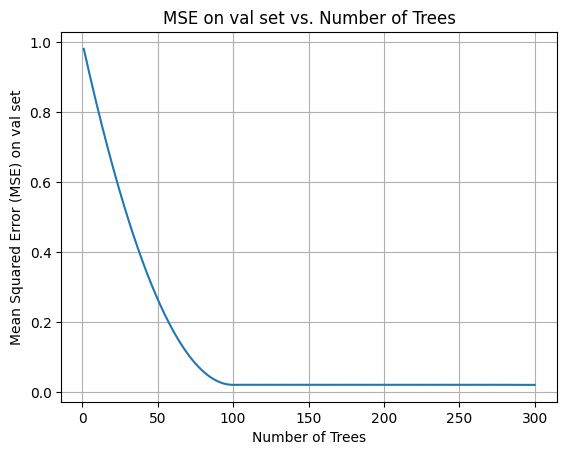

In [ ]:
plt.plot(range(1, 301), MSE_arr)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (MSE) on val set')
plt.title('MSE on val set vs. Number of Trees')
plt.grid(True)
plt.show()        

In [ ]:
no_of_trees = 1 ; min_MSE = MSE_arr[0]
for i in range(1 ,len(MSE_arr) ,1):
    if MSE_arr[i] <= min_MSE:
        no_of_trees = i+1
        min_MSE = MSE_arr[i]
print(f"The minimum MSE is coming at {no_of_trees} trees and the minimum MSE is {min_MSE}")

MSE_test = 0 
for j in range(len(X_test[0])):
    f_x = 0
    for k in range(no_of_trees):
        f_x += 0.01*( left_means[k]   if X_test[dimensions[k]][j] < splits[k] else right_means[k])    
    MSE_test += (f_x - y_selected_test[j])**2
print(f"The MSE for the test set is : {MSE_test / len(X_test[0])}")


The minimum MSE is coming at 299 trees and the minimum MSE is 0.019662254273380284
The MSE for the test set is : 0.015011203546894862
